# Intro

In this notebook we create an ensemble of deep learning models to predict GO annotations directly from animo acid sequences of human proteins.

We present EDA and cleaning of the protein and GO annotation data, validate the ensemble via a test set, back test the model against the most recent GO annotations, and finally present 3 novel GO annotation - protein associations predicted by our ensemble.

Also Included is a summary of the code changes made during this project.

In [3]:
# imports
import numpy as np
import tensorflow as tf
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [20]:
# Load the data CSV file as a dataframe
df = pd.read_csv('../data/seqSet.csv',header=None)
df.columns = ['Protein', 'Sequence']

# Load the metadata CSV file as a dataframe
meta_df = pd.read_csv('../data/humanProteinGO.csv',index_col='GO_Annatiation')


We start with 2 dataframes, one with protein to GO annotation association, and another with protein to amino acid sequence association

In [21]:
meta_df.head()

,GO:0001933,GO:0003151,GO:0007187,GO:0007611,GO:0008015,GO:0008277,GO:0009408,GO:0030218,GO:0030855,GO:0031018,...,GO:0005887,GO:0005739,GO:0005730,GO:0005576,GO:0005829,GO:0005886,GO:0016021,GO:0005634,GO:0005737,GO:0016020
GO_Annatiation,,,,,,,,,,,,,,,,,,,,,
Q8TBF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Q8TBF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Q5MIZ7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
P30613,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Q5H9L4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [22]:
df.head()

,Protein,Sequence
0,Q8TBF5,MAARVAAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEI...
1,Q8TBF4,MSGGLAPSKSTVYVSNLPFSLTNNDLYRIFSKYGKVVKVTIMKDKD...
2,Q5MIZ7,MSDTRRRVKVYTLNEDRQWDDRGTGHVSSTYVEELKGMSLLVRAES...
3,Q8TBF2,MSTVDLARVGACILKHAVTGEAVELRSLWREHACVVAGLRRFGCVV...
4,Q5H9L4,MECPEGQLPISSENDSTPTVSTSEVTSQQEPQILVDRGSETTYESS...


# EDA

~1000 go annotations. binary yes or no for inclusion in the protein

In [23]:
meta_df

,GO:0001933,GO:0003151,GO:0007187,GO:0007611,GO:0008015,GO:0008277,GO:0009408,GO:0030218,GO:0030855,GO:0031018,...,GO:0005887,GO:0005739,GO:0005730,GO:0005576,GO:0005829,GO:0005886,GO:0016021,GO:0005634,GO:0005737,GO:0016020
GO_Annatiation,,,,,,,,,,,,,,,,,,,,,
Q8TBF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Q8TBF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Q5MIZ7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
P30613,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Q5H9L4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8WXA9,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
Q8WXA8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
Q6ZSZ5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


First we check how many proteins each GO annotation has. This will tell us how imbalanced our classification problem is.

For each GO annotation, sum along the column of the binary indicators

In [24]:
go_annotation_sums = meta_df.sum(axis=0)

In [25]:
go_annotation_sums

GO:0001933      40
GO:0003151      40
GO:0007187      40
GO:0007611      40
GO:0008015      40
              ... 
GO:0005886    3596
GO:0016021    3745
GO:0005634    4798
GO:0005737    5142
GO:0016020    5391
Length: 1052, dtype: int64

Let's look at some basic stats of this and a histogram

In [26]:
go_annotation_sums.describe()

count    1052.000000
mean      163.108365
std       426.694682
min        20.000000
25%        41.000000
50%        62.000000
75%       121.000000
max      5775.000000
dtype: float64

Most are associated with very few. The graph below is very right skewed (long right tail)

Text(0, 0.5, 'Frequency')

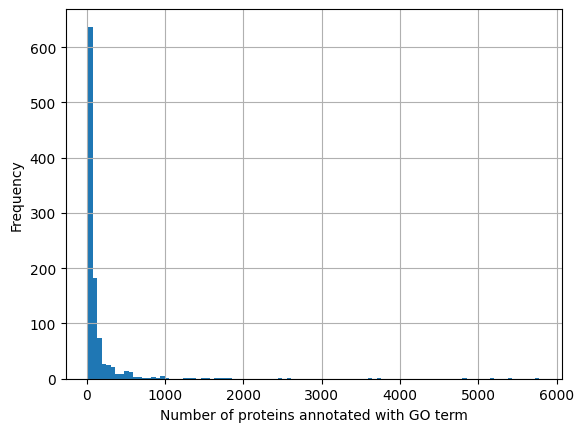

In [27]:
# Plot the distribution of the number of proteins annotated with each GO term
go_annotation_sums.hist(bins=100)

# label the axes
plt.xlabel('Number of proteins annotated with GO term')
plt.ylabel('Frequency')

Next let's look at the GO annotations that have the most proteins associated with them

In [28]:
go_annotation_sums.sort_values(ascending=False).head(20)

GO:0005515    5775
GO:0016020    5391
GO:0005737    5142
GO:0005634    4798
GO:0016021    3745
GO:0005886    3596
GO:0046872    2597
GO:0005829    2441
GO:0006355    1860
GO:0007165    1826
GO:0006351    1757
GO:0000166    1712
GO:0003677    1636
GO:0006810    1544
GO:0005576    1533
GO:0005730    1500
GO:0044281    1375
GO:0016787    1335
GO:0005739    1313
GO:0005524    1280
dtype: int64

Referencing these against the gene ontology database, we see that some of them have been replaced. For example, GO:0016021 is in our dataset, but it has been replaced by GO:0016020. We details these cases below, and resolve them by taking the logical OR of both GO annotations and then dropping the retired GO term

1) GO:0005515 protein binding
2) GO:0016020 membrane
3) GO:0005737 cytoplasm
4) GO:0005634 nucleus
5) GO:0016021 is replaced by GO:0016020 membrane see https://amigo.geneontology.org/amigo/term/GO:0016021
6) GO:0005886 plasma membrane
7) GO:0005829 cytosol
8) GO:0005576 extracellular region
9) GO:0005730 nucleolus
10) GO:0005739 mitochondrion
11) GO:0005887 replaced by GO:0005886 plasma membrane
12) GO:0005783 endoplasmic reticulum
13) GO:0005654 nucleoplasm

In [29]:
# logical OR of column GO:0016020 and GO:0016021, result into GO:0016020
meta_df['GO:0016020'] = meta_df['GO:0016020'] | meta_df['GO:0016021']

In [30]:
# drop column GO:0016021
meta_df = meta_df.drop(columns=['GO:0016021'])

In [31]:
meta_df['GO:0005886'] = meta_df['GO:0005886'] | meta_df['GO:0005887']

In [32]:
meta_df = meta_df.drop(columns=['GO:0005887'])

### How many Go annotations should we make models for? let's take a closer look at the GO to protein association frequency

Below, each x tick is a Go annotation, and the Y axis is how many proteins have that GO annotation. This is different from the histogram in that we are actually looking at each individual GO annotation rather than bucketing them

Text(0, 0.5, 'Number of proteins annotated with GO term')

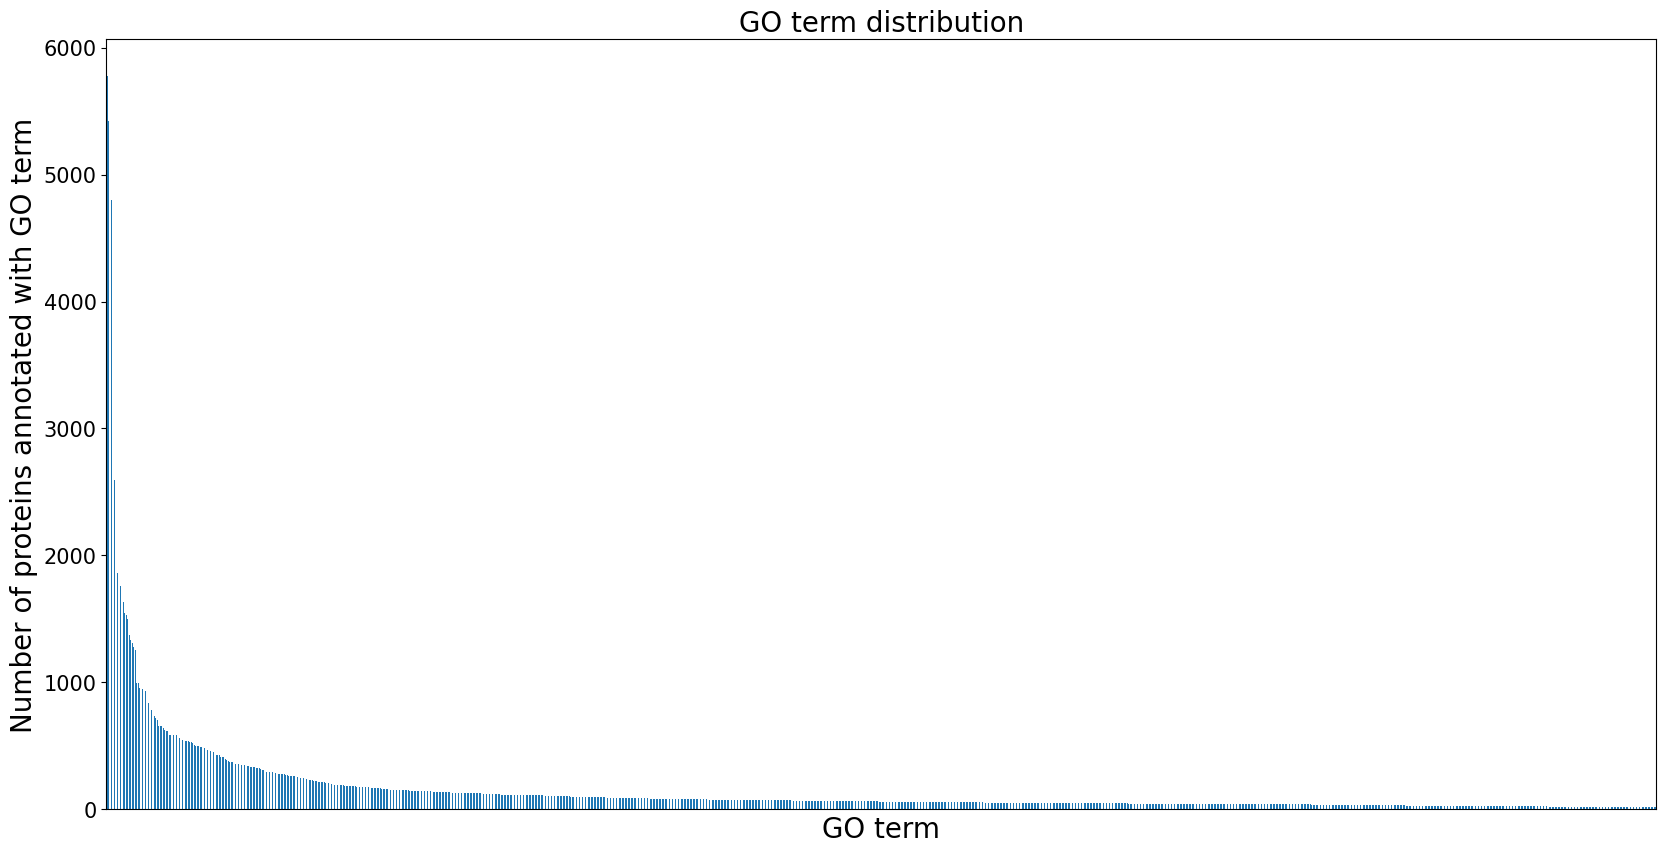

In [46]:
# plot meta_df.sum(axis=0) with no x ticks
meta_df.sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(20,10), rot=90, fontsize=15, xticks=[])

# title
plt.title('GO term distribution', fontsize=20)

# label the axes
plt.xlabel('GO term', fontsize=20)

plt.ylabel('Number of proteins annotated with GO term', fontsize=20)

Narrow down to the top 100

<Axes: >

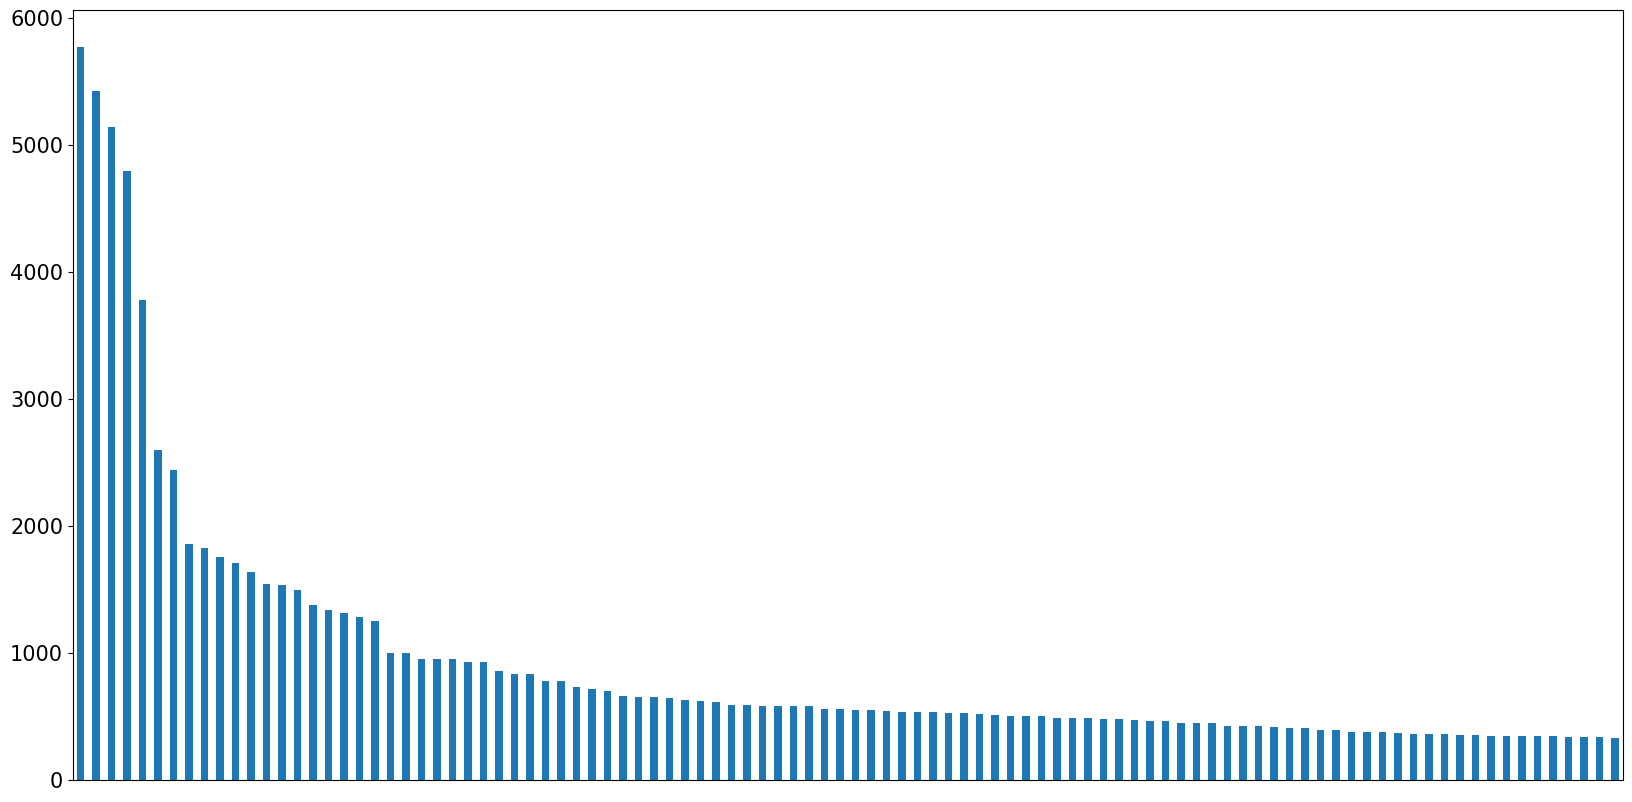

In [34]:
meta_df.sum(axis=0).sort_values(ascending=False).head(100).plot(kind='bar', figsize=(20,10), rot=90, fontsize=15, xticks=[])

The frequncy begins to plateau rapidly after the top 100, so we will define our model cutoff there

In [35]:
top_GO_col_names = meta_df.sum(axis=0).sort_values(ascending=False).head(100).index

What this means is that we will have 100 models in our ensemble, where each one is for predicting one of the GO annotations below

In [36]:
top_GO_col_names

Index(['GO:0005515', 'GO:0016020', 'GO:0005737', 'GO:0005634', 'GO:0005886',
       'GO:0046872', 'GO:0005829', 'GO:0006355', 'GO:0007165', 'GO:0006351',
       'GO:0000166', 'GO:0003677', 'GO:0006810', 'GO:0005576', 'GO:0005730',
       'GO:0044281', 'GO:0016787', 'GO:0005739', 'GO:0005524', 'GO:0016740',
       'GO:0005654', 'GO:0005783', 'GO:0004871', 'GO:0005856', 'GO:0005794',
       'GO:0007275', 'GO:0008270', 'GO:0003700', 'GO:0005622', 'GO:0007186',
       'GO:0003676', 'GO:0005615', 'GO:0006915', 'GO:0004930', 'GO:0045944',
       'GO:0010467', 'GO:0003723', 'GO:0003674', 'GO:0005789', 'GO:0045087',
       'GO:0003824', 'GO:0055085', 'GO:0007049', 'GO:0006811', 'GO:0016310',
       'GO:0016301', 'GO:0030154', 'GO:0008150', 'GO:0055114', 'GO:0042803',
       'GO:0030054', 'GO:0006468', 'GO:0007155', 'GO:0000122', 'GO:0045893',
       'GO:0015031', 'GO:0005575', 'GO:0005509', 'GO:0008152', 'GO:0050896',
       'GO:0043565', 'GO:0042995', 'GO:0044267', 'GO:0016491', 'GO:0043066',

### How many GO annotations does each protein have?

That is, for each protein, sum the number of binary indicators in its row.

Most of the proteins only have 0 - 20 GO annotations associated with them

In [37]:
protein_go_counts = meta_df.sum(axis=1)

<Axes: >

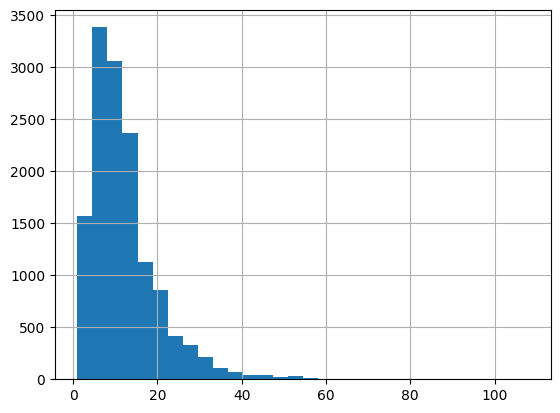

In [38]:
protein_go_counts.hist(bins=30)

Let's look again with only our top 100 GO annotations

<Axes: >

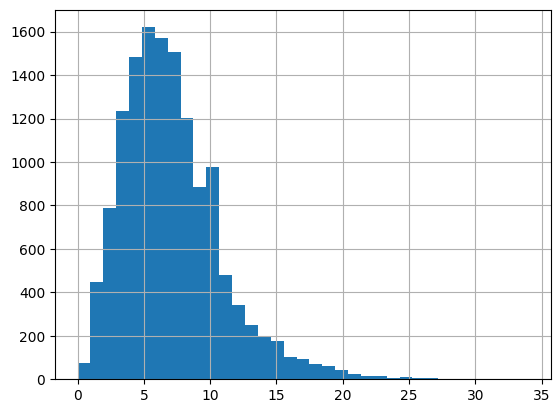

In [39]:
meta_df[top_GO_col_names].sum(axis=1).hist(bins=35)

As you can see, the skew of this graph is much less, which means that the data should behave much better when training a model

### Next, let's look at the amino acid sequence length of the proteins

In [40]:
sequence_length = df['Sequence'].apply(len)

In [41]:
sequence_length

0        258
1        217
2        849
3        198
4        462
        ... 
12982    508
12983    447
12984    286
12985    606
12986    585
Name: Sequence, Length: 12987, dtype: int64

### Distribution of amino acid sequence length

Text(0, 0.5, 'Frequency')

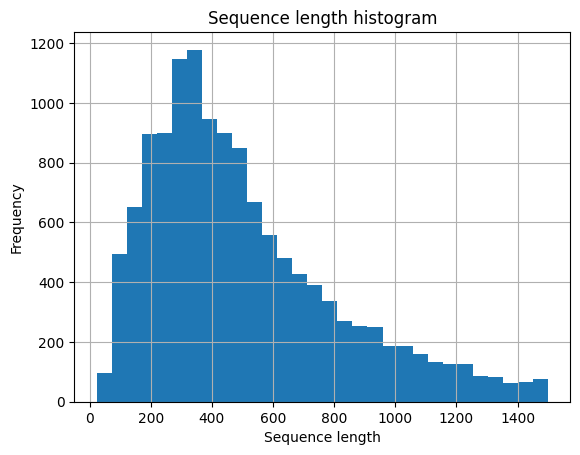

In [43]:
sequence_length.hist(bins=30)
# title sequence length histogram
plt.title('Sequence length histogram')
# label x axis
plt.xlabel('Sequence length')
# label y axis
plt.ylabel('Frequency')

Most are around 100 - 800 long, with some over 1400 long. To help out machine learning model learn, we should cut off the long tail of the distribution where it starts to plateau. The number we settled on here is 800

# Data Prep

Merge the dataframes

In [130]:
df = pd.merge(df, meta_df[top_GO_col_names], left_on='Protein', right_index=True, how='left')

In [131]:
df

,Protein,Sequence,GO:0005515,GO:0016020,GO:0005737,GO:0005634,GO:0005886,GO:0046872,GO:0005829,GO:0006355,...,GO:0008283,GO:0005813,GO:0006366,GO:0004984,GO:0050911,GO:0016874,GO:0019048,GO:0051301,GO:0035556,GO:0006357
0,Q8TBF5,MAARVAAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEI...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q8TBF4,MSGGLAPSKSTVYVSNLPFSLTNNDLYRIFSKYGKVVKVTIMKDKD...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Q5MIZ7,MSDTRRRVKVYTLNEDRQWDDRGTGHVSSTYVEELKGMSLLVRAES...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Q8TBF2,MSTVDLARVGACILKHAVTGEAVELRSLWREHACVVAGLRRFGCVV...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Q5H9L4,MECPEGQLPISSENDSTPTVSTSEVTSQQEPQILVDRGSETTYESS...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12982,Q8WXA9,MTSLMPGAGLLPIPTPNPLTTLGVSLSSLGAIPAAALDPNIATLGE...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12983,Q8WXA8,MEGGWPARQSALLCLTVSLLLQGRGDAFTINCSGFDQHGVDPAVFQ...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12984,O75323,MAARVLRARGAAWAGGLLQRAAPCSLLPRLRTWTSSSNRSREDSWL...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12985,Q8WXA3,MATKDPTAVERANLLNMAKLSIKGLIESALSFGRTLDSDYPPLQQF...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


fill NaN values with 0

In [132]:
df = df.fillna(0)

filter sequences with length > 800

In [133]:
df = df[df['Sequence'].apply(len) <= 800]

In [134]:
sequence_length = df['Sequence'].apply(len)

Recheck the sequence length distribution. There is no more long tail (heavy skew)

Text(0, 0.5, 'Frequency')

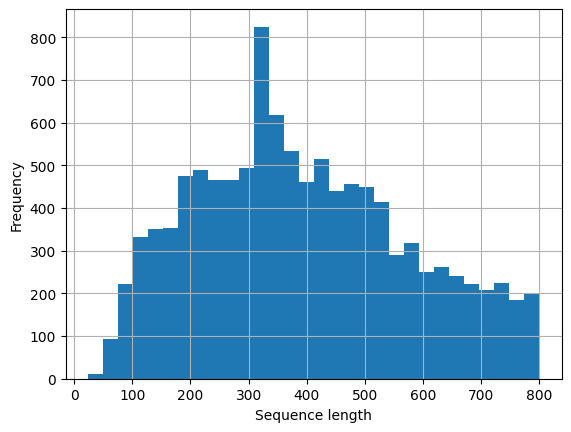

In [136]:
sequence_length.hist(bins=30)

# label the axes
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

Fix types (float -> int)

In [137]:
df[top_GO_col_names] = df[top_GO_col_names].astype(int)

In [53]:
df

,Protein,Sequence,GO:0005515,GO:0016020,GO:0005737,GO:0005634,GO:0005886,GO:0046872,GO:0005829,GO:0006355,...,GO:0008283,GO:0005813,GO:0006366,GO:0004984,GO:0050911,GO:0016874,GO:0019048,GO:0051301,GO:0035556,GO:0006357
0,Q8TBF5,MAARVAAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEI...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Q8TBF4,MSGGLAPSKSTVYVSNLPFSLTNNDLYRIFSKYGKVVKVTIMKDKD...,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Q8TBF2,MSTVDLARVGACILKHAVTGEAVELRSLWREHACVVAGLRRFGCVV...,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Q5H9L4,MECPEGQLPISSENDSTPTVSTSEVTSQQEPQILVDRGSETTYESS...,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Q9NQ76,MRVFCVGLLLFSVTWAAPTFQPQTEKTKQSCVEEQRQEEKNKDNIG...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12982,Q8WXA9,MTSLMPGAGLLPIPTPNPLTTLGVSLSSLGAIPAAALDPNIATLGE...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12983,Q8WXA8,MEGGWPARQSALLCLTVSLLLQGRGDAFTINCSGFDQHGVDPAVFQ...,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12984,O75323,MAARVLRARGAAWAGGLLQRAAPCSLLPRLRTWTSSSNRSREDSWL...,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12985,Q8WXA3,MATKDPTAVERANLLNMAKLSIKGLIESALSFGRTLDSDYPPLQQF...,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prep amino acids for input into model

We must one hot encode each amino acid in a sequence to input into our model. first we map each unique amino acid to an integer, then the integer to a one hot encoded vector.


Each letter is an amino acid. there are 22 amino acids, we can one hot encode them.

In [138]:
# Get all unique sequences characters from df['Sequence']
unique_chars = set(''.join(df['Sequence']))

In [139]:
unique_chars

{'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y'}

In [140]:
# Create a dictionary to map unique characters to integers
char_to_int = {char: i for i, char in enumerate(unique_chars)}

In [141]:
char_to_int

{'I': 0,
 'Q': 1,
 'X': 2,
 'U': 3,
 'E': 4,
 'P': 5,
 'N': 6,
 'D': 7,
 'W': 8,
 'V': 9,
 'M': 10,
 'S': 11,
 'H': 12,
 'T': 13,
 'R': 14,
 'F': 15,
 'G': 16,
 'C': 17,
 'L': 18,
 'A': 19,
 'K': 20,
 'Y': 21}

In [142]:
# function to one-hot encode a sequence
def one_hot_encode_sequence(sequence, char_to_int, seq_length):
    """
    One-hot encode a sequence using a character-to-integer mapping and a fixed sequence length
    """
    # Create an array of zeros with the required sequence length and number of possible characters
    encoding = np.zeros((seq_length, len(char_to_int)), dtype=np.int8)
    # Iterate over the characters in the input sequence
    for i, char in enumerate(sequence):
        # Get the integer encoding of the character
        char_index = char_to_int[char]
        # Set the appropriate element of the array to 1
        encoding[i, char_index] = 1
    return encoding

In [143]:
df['Sequence']

0        MAARVAAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEI...
1        MSGGLAPSKSTVYVSNLPFSLTNNDLYRIFSKYGKVVKVTIMKDKD...
3        MSTVDLARVGACILKHAVTGEAVELRSLWREHACVVAGLRRFGCVV...
4        MECPEGQLPISSENDSTPTVSTSEVTSQQEPQILVDRGSETTYESS...
5        MRVFCVGLLLFSVTWAAPTFQPQTEKTKQSCVEEQRQEEKNKDNIG...
                               ...                        
12982    MTSLMPGAGLLPIPTPNPLTTLGVSLSSLGAIPAAALDPNIATLGE...
12983    MEGGWPARQSALLCLTVSLLLQGRGDAFTINCSGFDQHGVDPAVFQ...
12984    MAARVLRARGAAWAGGLLQRAAPCSLLPRLRTWTSSSNRSREDSWL...
12985    MATKDPTAVERANLLNMAKLSIKGLIESALSFGRTLDSDYPPLQQF...
12986    MSATSVDQRPKGQGNKVSVQNGSIHQKDAVNDDDFEPYLSSQTNQS...
Name: Sequence, Length: 10866, dtype: object

In [144]:
# one hot encode all sequences
seq_length = sequence_length.max()
df['one-hot-sequence'] = df['Sequence'].apply(one_hot_encode_sequence, args=(char_to_int, seq_length))

/var/folders/63/zwtz8yx944j7c4y9ry_z0df80000gn/T/ipykernel_84774/3733526286.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['one-hot-sequence'] = df['Sequence'].apply(one_hot_encode_sequence, args=(char_to_int, seq_length))


To demonstrate more clearly what this is doing, please see the example below.

First, notice the "I" corresponds to the 0 index in our mapping, Q the first, and X the second.

We put that sequence of 3 amino acids in (in practice, you will enter the entire protein), specify the length and mapping, and get an array of length 3 x 22 (number of amino acids),
Where all numbers are zero except the index for each amino acid in the sequence.

## IMPORTANT NOTE
The char_to_int mapping can change on successive runs of the notebook. You may have a different mapping for I, Q, and X, and thus might not see a 1 in the 0th, 1st, and 2nd columns. In that case, observe that they will still correspond to whatever your mapping is

In [147]:
one_hot_encode_sequence('IQX', char_to_int, 3)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int8)

Next we split the data into train, test, and validation sets. 90 percent train,5 percent validation and 5 percent test

In [51]:
train_data, test_data = train_test_split(df, test_size=0.05, random_state=42)

In [52]:
train_data, val_data = train_test_split(train_data, test_size=0.05, random_state=42)

In [53]:
train_data

,Protein,Sequence,GO:0005515,GO:0016020,GO:0005737,GO:0005634,GO:0005886,GO:0046872,GO:0005829,GO:0006355,...,GO:0005813,GO:0006366,GO:0004984,GO:0050911,GO:0016874,GO:0019048,GO:0051301,GO:0035556,GO:0006357,one-hot-sequence
5481,Q8IWF6,MALRGPAGLGPGSRRPLDEAVAGAEGREAPALVAAGGAPEDDEEDD...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7722,O95377,MNWSIFEGLLSGVNKYSTAFGRIWLSLVFIFRVLVYLVTAERVWSD...,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
10984,Q5SQI0,MEFPFDVDALFPERITVLDQHLRPPARRPGTTTPARVDLQQQIMTI...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3448,O95156,MRLRPLPLVVVPGLLQLLFCDSKEVVHATEGLDWEDKDAPGTLVGN...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8733,Q8WVX9,MVSIPEYYEGKNVLLTGATGFLGKVLLEKLLRSCPKVNSVYVLVRQ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Q15768,MGPPHSGPGGVRVGALLLLGVLGLVSGLSLEPVYWNSANKRFQAEG...,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4505,P17812,MKYILVTGGVISGIGKGIIASSVGTILKSCGLHVTSIKIDPYINID...,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3334,P02748,MSACRSFAVAICILEISILTAQYTTSYDPELTESSGSASHIDCRMS...,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12760,O95389,MQGLLFSTLLLAGLAQFCCRVQGTGPLDTTPEGRPGEVSDAPQRKQ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Train

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [55]:
vocab_size = len(char_to_int)
input_length = sequence_length.max()

In [56]:
# input length is the length of the longest sequence
input_length

800

We create some helper functions to help us create, train, and test the 100 different models of our ensemble

In [57]:

def create_model(filters, kernel_size):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(input_length, vocab_size)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    # Adjust the final layer and activation according to your specific problem
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [58]:
def train_model(model, train_data, val_data, epochs, batch_size, Go_col):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # Create an EarlyStopping callback instance
    early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=3,  # How many epochs to wait after improvement
                               min_delta=0.001,  # Minimum change to qualify as an improvement
                               mode='min',  # The direction is "minimize" since we monitor 'val_loss'
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric.


    train_sequences = np.stack(train_data['one-hot-sequence'])
    train_labels = train_data[Go_col]

    val_sequences = np.stack(val_data['one-hot-sequence'])
    val_labels = val_data[Go_col]

    model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback, early_stopping])

    return model

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from sklearn import metrics

def evaluate_model(model, test_data, Go_col):
    # Prepare test data and labels
    test_sequences = np.stack(test_data['one-hot-sequence'])
    test_labels = test_data[Go_col].to_numpy()  # Convert to numpy array for compatibility with sklearn

    loss, accuracy = model.evaluate(test_sequences, test_labels)


    # Make predictions
    pred = model.predict(test_sequences)
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    return loss, accuracy, auc


In [60]:
def train_and_evaluate_model(test_data, filters, kernel_size, epochs, batch_size, Go_col):
    model = create_model(filters, kernel_size)
    model = train_model(model, train_data, val_data, epochs, batch_size, Go_col)
    loss, accuracy, auc = evaluate_model(model, test_data, Go_col)
    return model, loss, accuracy, auc

Train each model and save to a dictionary with its test set accuracy, loss, and AUC and the model itself

We train a deep learning model with a convolutional layer, max pooling layer, and finally a dense layer.

Number of filters (64) and length of convolution kernel (60) were determined emperically

In [61]:
results_dict = {}
for go_term in top_GO_col_names:
    print(f"Training model for {go_term}")
    model, loss, accuracy, auc = train_and_evaluate_model(test_data, 64, 60, 10, 32, go_term)
    print(f"Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}")

    results_dict[go_term] = {
        'loss': loss,
        'accuracy': accuracy,
        'auc': auc,
        'model': model
    }

Training model for GO:0005515


2024-04-11 17:55:38.871870: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-11 17:55:38.871900: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-11 17:55:38.871912: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-11 17:55:38.872136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 17:55:38.872479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-04-11 17:55:39.449776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - 5s 16ms/step - loss: 0.6834 - accuracy: 0.5948 - val_loss: 0.6669 - val_accuracy: 0.5977
Epoch 2/10
307/307 [==============================] - 5s 15ms/step - loss: 0.6318 - accuracy: 0.6302 - val_loss: 0.6360 - val_accuracy: 0.6480
Epoch 3/10
307/307 [==============================] - 5s 15ms/step - loss: 0.5675 - accuracy: 0.7053 - val_loss: 0.6396 - val_accuracy: 0.6441
Epoch 4/10
307/307 [==============================] - 5s 15ms/step - loss: 0.3022 - accuracy: 0.8799 - val_loss: 0.8247 - val_accuracy: 0.5938
Epoch 5/10
17/17 [==============================] - 0s 6ms/step
Loss: 0.6559157967567444, Accuracy: 0.59375, AUC: 0.6238580439453801
Training model for GO:0016020
Epoch 1/10
307/307 [==============================] - 5s 15ms/step - loss: 0.6279 - accuracy: 0.6469 - val_loss: 0.4748 - val_accuracy: 0.7950
Epoch 2/10
307/307 [==============================] - 5s 15ms/step - loss: 0.4494 - accuracy: 0.7961 - val_loss: 0.4352 - val_accurac

Our results dict contains 100 models, one for each GO annotation, each with the metrics on the test set

In [62]:
results_dict

{'GO:0005515': {'loss': 0.6559157967567444,
  'accuracy': 0.59375,
  'auc': 0.6238580439453801,
  'model': <keras.src.engine.sequential.Sequential at 0x2eddbabd0>},
 'GO:0016020': {'loss': 0.39899811148643494,
  'accuracy': 0.8235294222831726,
  'auc': 0.8705662277861715,
  'model': <keras.src.engine.sequential.Sequential at 0x326f25350>},
 'GO:0005737': {'loss': 0.604500412940979,
  'accuracy': 0.6525735259056091,
  'auc': 0.7251497005988023,
  'model': <keras.src.engine.sequential.Sequential at 0x319d96a50>},
 'GO:0005634': {'loss': 0.5090075731277466,
  'accuracy': 0.7224264740943909,
  'auc': 0.786945412311266,
  'model': <keras.src.engine.sequential.Sequential at 0x32ba96f10>},
 'GO:0005886': {'loss': 0.4543535113334656,
  'accuracy': 0.8125,
  'auc': 0.778762172922757,
  'model': <keras.src.engine.sequential.Sequential at 0x32bfbf990>},
 'GO:0046872': {'loss': 0.3940771818161011,
  'accuracy': 0.841911792755127,
  'auc': 0.7974350244013165,
  'model': <keras.src.engine.sequential

Save the results object for future loading and use

In [64]:
# pickle the results_dict
import pickle

with open('results_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)


Save char_to_int and sequence_length to a file since these are also needed for the model

In [78]:

import json

with open('char_to_int.json', 'w') as f:
    json.dump(char_to_int, f)

with open('sequence_length.txt', 'w') as f:
    f.write(str(sequence_length.max()))

Here we should that nearly all of the GO terms achieved over 80 percent accuracy on the test set

Text(0.5, 1.0, 'Test set accuracy for each GO term')

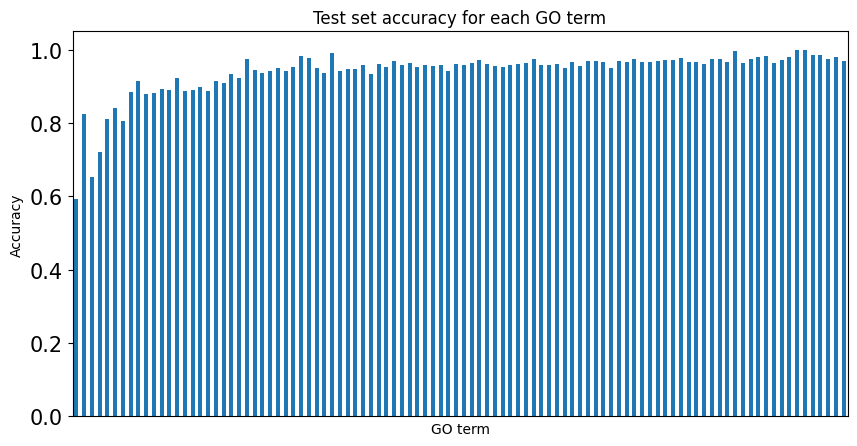

In [9]:
# barchart of accuracy from results_dict
accuracy_df = pd.DataFrame(results_dict).T['accuracy']

accuracy_df.plot(kind='bar', figsize=(10,5), rot=90, fontsize=15, xticks=[])
plt.xlabel('GO term')
plt.ylabel('Accuracy')

plt.title('Test set accuracy for each GO term')

In [5]:
# average Accuracy
accuracy_df.mean()

0.9401838266849518

And most acheived 60 or higher on AUC

Text(0.5, 1.0, 'Test set AUC')

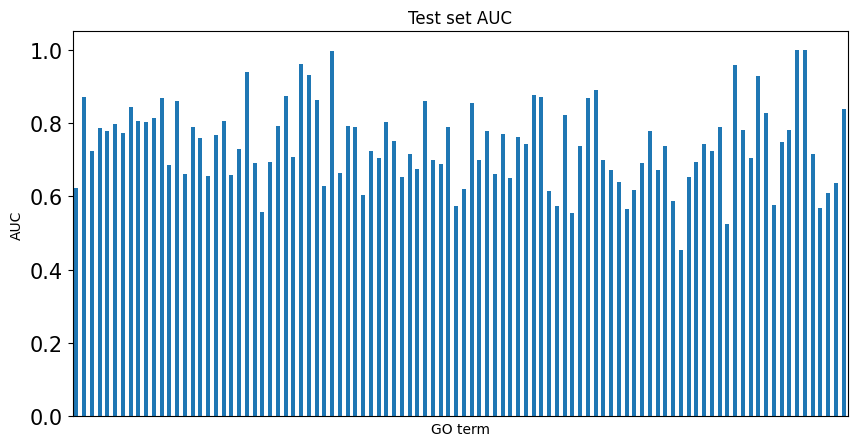

In [8]:
# barchart of AUC from results_dict
auc_df = pd.DataFrame(results_dict).T['auc']

auc_df.plot(kind='bar', figsize=(10,5), rot=90, fontsize=15, xticks=[])
plt.xlabel('GO term')
plt.ylabel('AUC')

# title test set AUC
plt.title('Test set AUC')

In [7]:
# average auc
auc_df.mean()


0.7426150063172051

Write function that takes in a sequence and GO term and returns the prediction

This is a wrapper function for our entire ensemble.

Parameters:

sequence: amino acid sequence

go_term: Term we want to predict is present in the sequence

results_dict: dictionary that contains our trained models

char_to_int: mapping from integer to amino acid. This was used as the first step in the one hot encoding. It needs to be the same mapping we used to train this particular set of models

sequence_length: max length of sequences we consider. We set ours to 800

In [64]:

def predict_GO_terms(sequence, go_term, results_dict, char_to_int, sequence_length):
    model = results_dict[go_term]['model']
    seq_length = sequence_length.max()
    
    one_hot_sequence = one_hot_encode_sequence(sequence, char_to_int, seq_length)
    one_hot_sequence = np.expand_dims(one_hot_sequence, axis=0)
    predictions = model.predict(one_hot_sequence, verbose=0)

    # upwrap the prediction from the array
    return predictions[0][0]

Example of how to use function. Note that the output is the probability that this sequence has GO annotation GO:0005886

In [76]:
# test the function
seq = 'MSSKSKPKDASQRRRSLEPAENVLGRKPRISVYRGVYVDDTQFVRFDSDAASPRGEPVLLGFLGKEDLRLFFVAPFVYVYERKKPIKIGSGAGKSTLLKELVHVDRAEGDFFYTGSGGVDYKLTGKIHVHAQRTHTGEKPYLCVYVYDVPDPRPAGDRTETKREAELAKHPKLSAIHRDLKSNNIFVHRDLAARNCMVAHDFTVKIGDFGMTRDIYETDYYRKGGKGLLPVRWMAPESLKDGVFTTSSDMWSFGVVLWEITSLAEQPYQGLSNEQVLKFVMDGGYLDQPDNCPEDLKTGHGKEISLRAPLPKPAATYRQRLATPSSRAGLQDAGVLRSSSGVPSGKQKPAVPRTPPAP'
predict_GO_terms(seq, 'GO:0005886', results_dict, char_to_int, sequence_length)

1/1 [==============================] - 0s 13ms/step


0.14154068

## Load model and char to int

In [2]:
import pickle
import json
# load results_dict
with open('../results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)

# load char_to_int
with open('../char_to_int.json', 'r') as f:
    char_to_int = json.load(f)

# load sequence_length
with open('../sequence_length.txt', 'r') as f:
    sequence_length = int(f.read())

2024-04-22 13:41:29.911759: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-22 13:41:29.911778: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-22 13:41:29.911784: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-22 13:41:29.912024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-22 13:41:29.913052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Retrospective testing

GO updates about every 4 weeks. you can download the latest here https://www.ebi.ac.uk/GOA/downloads.html

The GO annotations we trained with are from April 2023. We compare their difference with the most recent GO annotations about 1 year later

First, create a function to compare our humanProteinGO.csv to the most recent GO annotation from EMBL's European Bioinformatics Institute

In [23]:
import csv
from goatools.anno.gaf_reader import GafReader

def compare_csv_gaf(csv_file, gaf_file):
    # Read the CSV file and build a dictionary of proteins to GO annotations
    protein_to_go_csv = {}
    with open(csv_file, mode='r') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)[1:]  # Skip the first header ('protein') and get GO headers
        for row in csv_reader:
            protein = row[0]
            go_annotations = {headers[i] for i in range(len(row[1:])) if int(row[i + 1]) == 1}
            protein_to_go_csv[protein] = go_annotations

    # Initialize GafReader and read GO annotations from the GAF file
    gaf_reader = GafReader(gaf_file)
    protein_to_go_gaf = {}
    for assoc in gaf_reader.associations:
        if assoc.DB_ID not in protein_to_go_gaf:
            protein_to_go_gaf[assoc.DB_ID] = set()
        protein_to_go_gaf[assoc.DB_ID].add(assoc.GO_ID)

    # Compare and find new GO annotations in the GAF file that are not in the CSV file
    new_annotations = {}
    for protein, go_set in protein_to_go_gaf.items():
        if protein in protein_to_go_csv:
            new_gos = go_set - protein_to_go_csv[protein]
            if new_gos:
                new_annotations[protein] = new_gos

    return new_annotations, protein_to_go_csv, protein_to_go_gaf


new_annotations is the newly found GO annotations for human proteins over the last year

In [24]:
# Example usage:
file1_path = "data/humanProteinGO.csv"
file2_path = "goa_human_latest.gaf"

new_annotations, protein_to_go_csv, protein_to_go_gaf = compare_csv_gaf(file1_path, file2_path)



HMS:0:00:08.358246 641,150 annotations READ: goa_human_latest.gaf 


We have the new GO annotations for all GO annotations (~10k) for all human proteins, but we only trained models for the top 100 GO annotations. Here we filter the new go annotations by the ones we have models for

Next we check if any of our 100 models can predict these newly found GO annotations

In [28]:
new_annotations_with_model = {k: v for k, v in new_annotations.items() if v.intersection(set(top_GO_col_names))}

We find that there are many proteins that have newly found GO annotations which our models can predict. Each key is a human protein, the list of values are the GO annotations that are present for that protein in the new GO annotations file and not present for that protein in the data that we trained on. Additionally, the GO annotations are also ones that we have a model to predict

In [29]:
new_annotations_with_model

{'A0AVF1': {'GO:0005813',
  'GO:0007224',
  'GO:0015031',
  'GO:0030992',
  'GO:0035082',
  'GO:0035720',
  'GO:0035735',
  'GO:0036064',
  'GO:0042073',
  'GO:0043005',
  'GO:0060271',
  'GO:0061512',
  'GO:0097542',
  'GO:0097546',
  'GO:0120170',
  'GO:1905198'},
 'A0AVI4': {'GO:0000209',
  'GO:0005783',
  'GO:0005789',
  'GO:0006511',
  'GO:0006986',
  'GO:0016567',
  'GO:0030970',
  'GO:0036503',
  'GO:0046872',
  'GO:0061630'},
 'A0AVK6': {'GO:0000785',
  'GO:0000978',
  'GO:0000981',
  'GO:0000987',
  'GO:0001217',
  'GO:0001227',
  'GO:0001890',
  'GO:0002040',
  'GO:0005654',
  'GO:0005730',
  'GO:0005829',
  'GO:0006357',
  'GO:0032466',
  'GO:0032877',
  'GO:0033301',
  'GO:0048144',
  'GO:0060707',
  'GO:0060718',
  'GO:0070365',
  'GO:0090575',
  'GO:1990837'},
 'A0AVT1': {'GO:0004792',
  'GO:0004839',
  'GO:0005634',
  'GO:0005829',
  'GO:0006974',
  'GO:0007612',
  'GO:0007626',
  'GO:0016779',
  'GO:0019780',
  'GO:0021764',
  'GO:0021766',
  'GO:0060996'},
 'A0FGR8': {

Helper dictionary for evaluation

In [154]:
# invert to get GO to protein
go_to_protein = {}
for protein, go_set in protein_to_go_csv.items():
    for go in go_set:
        if go not in go_to_protein:
            go_to_protein[go] = set()
        go_to_protein[go].add(protein)

To be safe, we ensure that we only select proteins that we also have in our data

In [76]:
# get intersection of proteins in df and new_annotations_with_model
proteins_in_df = set(df['Protein'])
proteins_in_new_annotations = set(new_annotations_with_model.keys())

common_proteins = proteins_in_df.intersection(proteins_in_new_annotations)

In [193]:
len(common_proteins)

8387

In [77]:
common_proteins

{'O95971',
 'Q9H1K0',
 'Q9NUI1',
 'Q9H9L4',
 'Q9H9T3',
 'Q8N7X4',
 'Q92913',
 'P01588',
 'P59542',
 'Q9BWF2',
 'Q8NBQ7',
 'Q9H6X2',
 'Q92542',
 'Q9H7E2',
 'P15509',
 'P20036',
 'Q02221',
 'Q99583',
 'O75594',
 'Q9UDV7',
 'Q8WVD3',
 'Q9Y3C0',
 'P61221',
 'Q96PF2',
 'Q9H2S1',
 'Q99836',
 'Q9NY12',
 'Q6IEY1',
 'Q96GR2',
 'P14555',
 'O14576',
 'P49842',
 'P13378',
 'Q9UPQ4',
 'Q9Y6X1',
 'Q99807',
 'P45877',
 'O14829',
 'O95639',
 'P17174',
 'Q96JA3',
 'Q9BRK5',
 'O95475',
 'P56746',
 'Q92565',
 'Q53QV2',
 'P17483',
 'Q86YT5',
 'P17342',
 'P58004',
 'Q9NPC1',
 'Q9NX24',
 'Q96FW1',
 'Q9H2A2',
 'P08047',
 'P51523',
 'O00409',
 'P11117',
 'Q5T752',
 'Q9BXT2',
 'P17612',
 'Q9Y264',
 'P56211',
 'Q9UBU3',
 'O43895',
 'Q10589',
 'Q03405',
 'Q9BS34',
 'Q9H3J6',
 'Q9BUL9',
 'Q9Y6M1',
 'Q9H4M9',
 'P62891',
 'O43614',
 'P15407',
 'P43361',
 'Q86UD3',
 'P30405',
 'O00155',
 'Q9Y606',
 'P29017',
 'P28223',
 'Q96PD4',
 'P29016',
 'Q96N76',
 'P13688',
 'Q6PCT2',
 'Q9UM44',
 'P40222',
 'O75414',
 'Q99584',

Since there are so many novel annotations to predict, we randomly sample 100 proteins that have new annotations and just predict for those

In [79]:
# random sample of 100 proteins
import random

random_proteins = random.sample(list(common_proteins), 100)

In [80]:
# get proteins sequences that are the keys in new_annotations_with_model
new_annotations_sequences = df[df['Protein'].isin(random_proteins)]

These are the sequences for which we will try to "rediscover" their novel GO annotations found in the past year

In [81]:
new_annotations_sequences

,Protein,Sequence,GO:0005515,GO:0016020,GO:0005737,GO:0005634,GO:0005886,GO:0046872,GO:0005829,GO:0006355,...,GO:0005813,GO:0006366,GO:0004984,GO:0050911,GO:0016874,GO:0019048,GO:0051301,GO:0035556,GO:0006357,one-hot-sequence
184,Q00535,MQKYEKLEKIGEGTYGTVFKAKNRETHEIVALKRVRLDDDDEGVPS...,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
254,Q5RKV6,MPGDHRRIRGPEESQPPQLYAADEEEAPGTRDPTRLRPVYARAGLL...,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
514,P56559,MGNISSNISAFQSLHIVMLGLDSAGKTTVLYRLKFNEFVNTVPTIG...,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
793,P17677,MLCCMRRTKQVEKNDDDQKIEQDGIKPEDKAHKAATKIQASFRGHI...,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1108,Q99551,MQSLSLGQTSISKGLNYLTIMAPGNLWHMRNNFLFGSRCWMTRFSA...,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12327,Q6NZY4,MAAEVYFGDLELFEPFDHPEESIPKPVHTRFKDDDGDEEDENGVGD...,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12392,O60506,MATEHVNGNGTEEPMDTTSAVIHSENFQTLLDAGLPQKVAEKLDEI...,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12418,O75461,MSQQRPARKLPSLLLDPTEETVRRRCRDPINVEGLLPSKIRINLED...,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12809,P18827,MRRAALWLWLCALALSLQPALPQIVATNLPPEDQDGSGDDSDNFSG...,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Do the prediction

In [83]:
# predict GO terms for the sequences
predictions_df = new_annotations_sequences.copy()

for i, go_term in enumerate(top_GO_col_names):
    print(f"Predicting GO term {go_term} ({i+1}/{len(top_GO_col_names)})")
    predictions_df[go_term] = new_annotations_sequences['Sequence'].apply(predict_GO_terms, args=(go_term, results_dict, char_to_int, sequence_length))

Predicting GO term GO:0005515 (1/100)
Predicting GO term GO:0016020 (2/100)
Predicting GO term GO:0005737 (3/100)
Predicting GO term GO:0005634 (4/100)
Predicting GO term GO:0005886 (5/100)
Predicting GO term GO:0046872 (6/100)
Predicting GO term GO:0005829 (7/100)
Predicting GO term GO:0006355 (8/100)
Predicting GO term GO:0007165 (9/100)
Predicting GO term GO:0006351 (10/100)
Predicting GO term GO:0000166 (11/100)
Predicting GO term GO:0003677 (12/100)
Predicting GO term GO:0006810 (13/100)
Predicting GO term GO:0005576 (14/100)
Predicting GO term GO:0005730 (15/100)
Predicting GO term GO:0044281 (16/100)
Predicting GO term GO:0016787 (17/100)
Predicting GO term GO:0005739 (18/100)
Predicting GO term GO:0005524 (19/100)
Predicting GO term GO:0016740 (20/100)
Predicting GO term GO:0005654 (21/100)
Predicting GO term GO:0005783 (22/100)
Predicting GO term GO:0004871 (23/100)
Predicting GO term GO:0005856 (24/100)
Predicting GO term GO:0005794 (25/100)
Predicting GO term GO:0007275 (26/

We put the probability of each protein - GO association

In [148]:
predictions_df.head()

,Protein,Sequence,GO:0005515,GO:0016020,GO:0005737,GO:0005634,GO:0005886,GO:0046872,GO:0005829,GO:0006355,...,GO:0005813,GO:0006366,GO:0004984,GO:0050911,GO:0016874,GO:0019048,GO:0051301,GO:0035556,GO:0006357,one-hot-sequence
184,Q00535,MQKYEKLEKIGEGTYGTVFKAKNRETHEIVALKRVRLDDDDEGVPS...,0.533533,0.111272,0.516095,0.627694,0.135287,0.100262,0.686006,0.046265,...,0.030867,0.018443,5.196177e-10,3.927773e-11,0.010102,0.035625,0.627561,0.018257,0.006027,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
254,Q5RKV6,MPGDHRRIRGPEESQPPQLYAADEEEAPGTRDPTRLRPVYARAGLL...,0.473862,0.069338,0.460540,0.466220,0.046447,0.041974,0.312122,0.061096,...,0.024131,0.049440,1.274361e-12,3.266094e-13,0.007862,0.032850,0.001881,0.005995,0.039319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
514,P56559,MGNISSNISAFQSLHIVMLGLDSAGKTTVLYRLKFNEFVNTVPTIG...,0.421334,0.450298,0.286167,0.242571,0.252471,0.031021,0.090722,0.036267,...,0.017112,0.009114,1.230621e-16,3.027124e-14,0.006407,0.037959,0.101659,0.002273,0.005990,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
793,P17677,MLCCMRRTKQVEKNDDDQKIEQDGIKPEDKAHKAATKIQASFRGHI...,0.531011,0.035362,0.410139,0.654776,0.022860,0.125882,0.227873,0.359049,...,0.059112,0.109840,7.707396e-20,8.758408e-21,0.014079,0.057992,0.111344,0.003366,0.101096,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1108,Q99551,MQSLSLGQTSISKGLNYLTIMAPGNLWHMRNNFLFGSRCWMTRFSA...,0.518406,0.339381,0.197958,0.162566,0.154629,0.040164,0.088771,0.053066,...,0.030200,0.016055,5.500511e-16,2.076174e-13,0.006104,0.034652,0.023590,0.010842,0.005500,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [87]:
from sklearn.metrics import accuracy_score

In [192]:
# Get accuracy for each GO term
cut_off = 0.5
results = {}
for go_term in top_GO_col_names:
    y_true = new_annotations_sequences[[go_term, 'Protein']]
    y_pred = predictions_df[[go_term, 'Protein']]
    # remove rows that do not have a value for the GO term in go_to_protein
    valid_proteins = go_to_protein[go_term]

    y_true = y_true[y_true['Protein'].isin(valid_proteins)]
    y_pred = y_pred[y_pred['Protein'].isin(valid_proteins)]

    y_true = y_true[go_term]
    y_pred = y_pred[go_term]

    if y_true.empty or y_pred.empty:
        continue

    y_pred = y_pred.apply(lambda x: 1 if x >= cut_off else 0)

    accuracy = accuracy_score(y_true, y_pred)
    results[go_term] = {'accuracy': accuracy}

# print average accuracy
sum([v['accuracy'] for v in results.values()]) / len(results)



0.1986713747082411

## This demonstrates that we are able to predict newly discovered GO annotations with 19.86 percent accuracy

This is low for most machine learning results, but what we are trying to do here is incredibly hard and it would be a breakthrough if it could be done with high accuracy

### Finally, we check if our model has high confidence (>90%) about any Protein - GO associations that are not in the most up to date version of EMBL's European Bioinformatics Institute

In [105]:
# Find highest accuracy "false positive" predictions
high_cutt_off = 0.9
false_positives = {}
for go_term in top_GO_col_names:
    y_true = new_annotations_sequences[go_term]
    y_pred = predictions_df[go_term]
    y_pred = y_pred.apply(lambda x: 1 if x >= high_cutt_off else 0)
    if new_annotations_sequences[(y_true == 0) & (y_pred == 1)].shape[0] > 0:
        false_positives[go_term] = new_annotations_sequences[(y_true == 0) & (y_pred == 1)][['Protein', 'Sequence']]

We find 3 potentially new associations. These are labeled as false positives, but given our models efficacy in both the test set evaluation and the retrospective test evaluation, these novel associations may warrant investigation

In [106]:
false_positives

{'GO:0016020':      Protein                                           Sequence
 6572  Q9UMS5  MASNERDAISWYQKKIGAYDQQIWEKSIEQTQIKGLKNKPKKMGHI...,
 'GO:0000166':      Protein                                           Sequence
 8860  O95218  MSTKNFRVSDGDWICPDKKCGNVNFARRTSCNRCGREKTTEAKMMK...,
 'GO:0005524':       Protein                                           Sequence
 12871  Q13061  MTEITAEGNASTTTTVIDSKNGSVPKSPGKVLKRTVTEDIVTTFSS...}

https://www.ebi.ac.uk/QuickGO/term/GO:0000166 (binding nucleotide) https://www.uniprot.org/uniprotkb/O95218/entry

https://www.ebi.ac.uk/QuickGO/term/GO:0016020 membrane https://www.uniprot.org/uniprotkb/Q9UMS5/entry

https://www.ebi.ac.uk/QuickGO/term/GO:0005524 ATP binding https://www.uniprot.org/uniprotkb/Q13061/entry

## Code change history

Below is a list of things I implemented and tried throughout this project

- EDA
- Cleaned dataset by finding several retired GO annotations
- Multilabel classification
- Hyper parameter search over neural network architecture, e.g. more layers, larger convolution size
- Attention based mechanisms
- Learning dense embedding over the one hot encoding
- Added validation dataset to do early stopping
- Computed metrics on test set
- Simplifying the problem in multiple ways:
    - Reducing the max length of sequence predicted on
    - Reducing the number of classes predicted on
- Switched from multilabel classification to ensemble of binary classifiers
- Got most recent GO annotation data and calculated difference between it and the set we trained on
- Evaluated performance on the newly found GO annotations
- Found 3 potential novel protein - GO annotation associations from our trained models
